In [2]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw


# Augment Data

In [3]:
def alter_HSV(img, change_probability = 0.6):
    if random.random() < 1-change_probability:
        return img
    addToHue = random.randint(0,179)
    addToSaturation = random.gauss(60, 20)
    addToValue = random.randint(-50,50)
    hsvVersion =  cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    channels = hsvVersion.transpose(2, 0, 1)
    channels[0] = ((channels[0].astype(int) + addToHue)%180).astype(np.uint8)
    channels[1] = (np.maximum(0, np.minimum(255, (channels[1].astype(int) + addToSaturation)))).astype(np.uint8)
    channels[2] = (np.maximum(0, np.minimum(255, (channels[2].astype(int) + addToValue)))).astype(np.uint8)
    hsvVersion = channels.transpose(1,2,0)   
        
    return cv2.cvtColor(hsvVersion, cv2.COLOR_HSV2RGB)

#%%
def image_drop(img, change_probability = 0.6):
    if random.random() < 1-change_probability:
        return img
    width = random.randint(int(img.shape[1]*0.10), int(img.shape[1]*0.3))
    height = random.randint(int(img.shape[0]*0.10), int(img.shape[0]*0.3))
    x = random.randint(int(img.shape[1]*0.10), img.shape[1]-width-int(img.shape[1]*0.10))
    y = random.randint(int(img.shape[0]*0.10), img.shape[0]-height-int(img.shape[0]*0.10))
    img[y:y+height,x:x+width,:] = (np.random.rand(height,width,3)*255).astype(np.uint8)
    return img

#%%
def add_bb_noise_flip(image, bb3d, flip, bb_noise):
    bb3d = bb3d + bb_noise 
    if flip:
        bb3d[:, 0] = image.shape[1] - bb3d[:,0]
        image = cv2.flip(image, 1)
    return image, bb3d

#%%
def _unpack_side(img, origPoints, targetSize):
    origPoints = np.array(origPoints).reshape(-1,1,2)
    targetPoints = np.array([(0,0), (targetSize[0],0), (0, targetSize[1]), 
                             (targetSize[0], targetSize[1])]).reshape(-1,1,2).astype(origPoints.dtype)
    m, _ = cv2.findHomography(origPoints, targetPoints, 0)
    resultImage = cv2.warpPerspective(img, m, targetSize)
    return resultImage
    
    
#%%    
def unpack_3DBB(img, bb):
    frontal = _unpack_side(img, [bb[0], bb[1], bb[4], bb[5]], (75,124))
    side = _unpack_side(img, [bb[1], bb[2], bb[5], bb[6]], (149,124))
    roof = _unpack_side(img, [bb[0], bb[3], bb[1], bb[2]], (149,100))
    
    final = np.zeros((224,224,3), dtype=frontal.dtype)
    final[100:, 0:75] = frontal
    final[0:100, 75:] = roof
    final[100:, 75:] = side
    
    return final

# Reading in image and boxcar files

In [4]:

def get_vehicle_instance_data(vehicle_id, instance_id, original_image_coordinates=False):
    """
    original_image_coordinates: the 3DBB coordinates are in the original image space
                                to convert them into cropped image space, it is necessary to subtract instance["3DBB_offset"]
                                which is done if this parameter is False. 
    """
    vehicle = dataset["samples"][vehicle_id]
    instance = vehicle["instances"][instance_id]
    bb3d = instance["3DBB"]
    bb3d = bb3d - instance["3DBB_offset"]

    return vehicle, instance, bb3d

def get_image(vehicle_id, instance_id):
    return cv2.cvtColor(cv2.imdecode(atlas[vehicle_id][instance_id], 1), cv2.COLOR_BGR2RGB)
def load_cache(path, encoding="latin-1", fix_imports=True):
        """
        encoding latin-1 is default for Python2 compatibility
        """
        with open(path, "rb") as f:
            return pickle.load(f, encoding=encoding, fix_imports=True)


In [5]:
cars_annotations = []
split = load_cache('../data/BoxCars/classification_splits.pkl')['hard']
dataset = load_cache('../data/BoxCars/dataset.pkl')
atlas = load_cache('../data/BoxCars/atlas.pkl')

In [6]:
i=0
vehicle_id, instance_id = 0,0
vehicle, instance, bb3d = get_vehicle_instance_data(vehicle_id, instance_id)
before_image = get_image(vehicle_id, instance_id)

image = get_image(vehicle_id, instance_id)
x = np.empty([1] + list((224,224)) + [3], dtype=np.float32)
if False:
    image = alter_HSV(image) # randomly alternate color
    image = image_drop(image) # randomly remove part of the image
    bb_noise = np.clip(np.random.randn(2) * 1.5, -5, 5) # generate random bounding box movement
    flip = bool(random.getrandbits(1)) # random flip
    image, bb3d = add_bb_noise_flip(image, bb3d, flip, bb_noise) 
image = unpack_3DBB(image, bb3d) 
# print(type(image))
# image = (image.astype(np.float32) - 116)/128.
# x[i, ...] = image


In [31]:
fn = '/Users/martinodonnell/Documents/uni/fourth_year/4006/LowResImageRecognision/data/BoxCars/images/uvoz/0/000000_002.png'
img = Image.open(fn)
img = np.array(img)

img = alter_HSV(img) # randomly alternate color
img = image_drop(img) # randomly remove part of the image
bb_noise = np.clip(np.random.randn(2) * 1.5, -5, 5) # generate random bounding box movement
flip = bool(random.getrandbits(1)) # random flip
img, bb3d = add_bb_noise_flip(img, bb3d, flip, bb_noise) 

img = unpack_3DBB(img, bb3d) 
img = (img.astype(np.float32) - 116)/128.
print(type(img))

img = Image.fromarray(img)
img

<class 'numpy.ndarray'>


TypeError: Cannot handle this data type

In [31]:
bb3d

array([[142.407 , 256.968 ],
       [110.31  , 260.801 ],
       [ 70.7555, 251.756 ],
       [101.034 , 248.509 ],
       [144.408 , 290.814 ],
       [112.576 , 295.644 ],
       [ 73.0434, 283.458 ],
       [103.09  , 279.384 ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


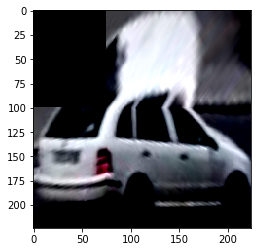

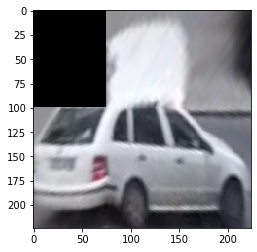

In [121]:
vehicle_id, instance_id = 0,1
vehicle, instance, bb3d = get_vehicle_instance_data(vehicle_id, instance_id)
image = get_image(vehicle_id, instance_id)
if True:
#     image = alter_HSV(image) # randomly alternate color
#     image = image_drop(image) # randomly remove part of the image
    bb_noise = np.clip(np.random.randn(2) * 1.5, -5, 5) # generate random bounding box movement
    flip = bool(random.getrandbits(1)) # random flip
    image, bb3d = add_bb_noise_flip(image, bb3d, flip, bb_noise) 
image = unpack_3DBB(image, bb3d) 

# image2 = (image.astype(np.float32) - 116)/128.
plt.imshow(image2)
plt.show()

image = Image.fromarray(image)
plt.imshow(image)
plt.show()


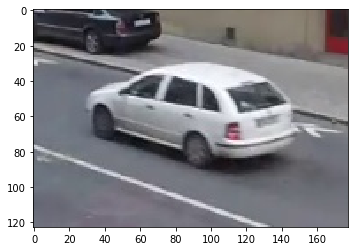

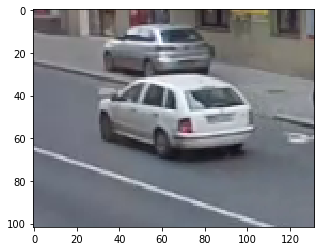

In [101]:
image = get_image(vehicle_id, instance_id)
plt.imshow(image)
plt.show()
img = Image.open(fn)
plt.imshow(img)
plt.show()


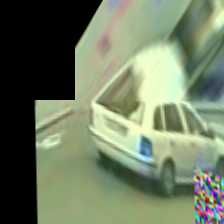

In [94]:
vehicle, instance, bb3d = get_vehicle_instance_data(vehicle_id, instance_id)
image = get_image(vehicle_id, instance_id)

vehicle['instances'][0]['path']

fn = '/Users/martinodonnell/Documents/uni/fourth_year/4006/LowResImageRecognision/data/BoxCars/images/' + vehicle['instances'][0]['path']

img = Image.open(fn)
#Convert from pil to cv
img = np.array(img)

if True:
    img = alter_HSV(img) # randomly alternate color
    img = image_drop(img) # randomly remove part of the image
    bb_noise = np.clip(np.random.randn(2) * 1.5, -5, 5) # generate random bounding box movement
    flip = bool(random.getrandbits(1)) # random flip
    img, bb3d = add_bb_noise_flip(img, bb3d, flip, bb_noise) 

img = unpack_3DBB(img, bb3d) 
# img = (img.astype(np.float32) - 116)/128.

img = Image.fromarray(img)
img
# plt.imshow(img)
